# Energy price forecasting for green batteries
This notebook is part of the work produced within the Melbourne machine learning and AI community's Green Battery Hack. The aim of the hack was to charge and discharge a battery connected to a pv cell connected to the grid, in order to make money by selling energy on the Australian energy market. Predicting the price of energy is therefore essential in deciding what action to take. We decided to use a long-short term model to predict the price, which is at the core of our larger decision logic.

# Import libraries

In [1]:
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn

# Load data

In [2]:
data = pd.read_csv(filepath_or_buffer='training_data.csv',
                   usecols=['timestamp', 'price'],
                   parse_dates=['timestamp'])
data.head()

,timestamp,price
0,2021-01-01 00:00:00,32.30093
1,2021-01-01 00:05:00,37.23402
2,2021-01-01 00:10:00,36.67139
3,2021-01-01 00:15:00,36.03389
4,2021-01-01 00:20:00,34.92372


In [3]:
# quick description of the data
data.describe()

,timestamp,price
count,299473,299473.000000
mean,2022-06-04 21:59:59.999999232,98.297819
min,2021-01-01 00:00:00,-1000.000000
25%,2021-09-17 23:00:00,8.696680
50%,2022-06-04 22:00:00,60.125530
75%,2023-02-19 21:00:00,126.337550
max,2023-11-06 20:00:00,16600.000000
std,NaN,423.205410


## Plot data
Visually inspect the energy price in the market to be modelled.

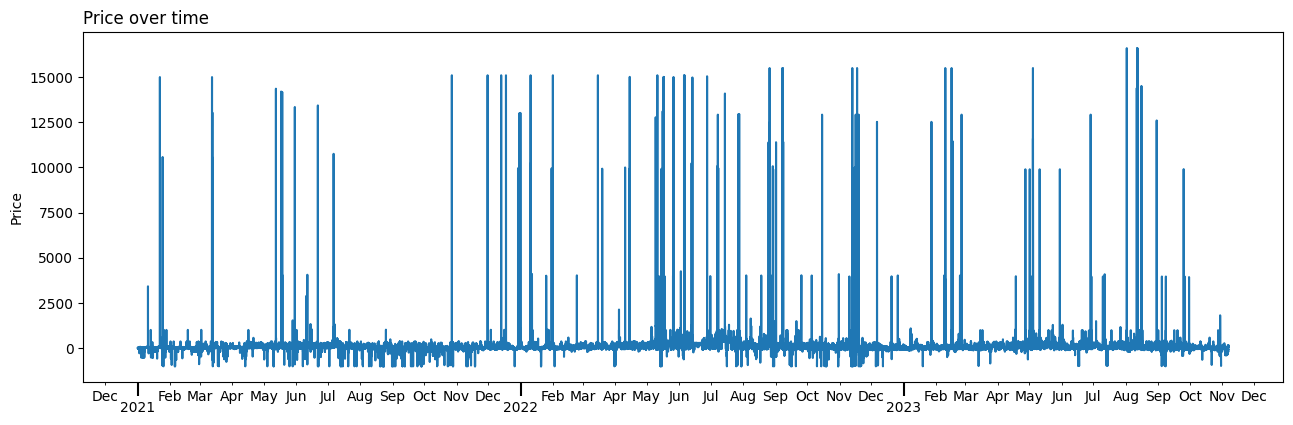

In [4]:
def plot_time_series(x, y, feat_name='price'):
    # Plot time series data
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(x, y)

    # Set major and minor ticks for x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    # adjust length and with of major x-ticks
    ax.tick_params(axis="x", which="major", length=10, width=1.5)

    # Add labels and title
    feat_name = feat_name.capitalize()
    ax.set_ylabel(f'{feat_name}')
    ax.set_title(f'{feat_name} over time', loc='left')

    # Adjust plot margins
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    

plot_time_series(data['timestamp'], data['price'], feat_name='Price')
plt.show()

The plot shows that there are very few short peaks that can be considered outliers. To improve the ability of a model to accurately model the price, the outliers need to be removed.

## Clean outliers
Outliers are cleaned using z-score thresholding, i.e., values that are more than a certain number of standard deviations away from the mean are considered outliers and are removed from the dataset.
- Approximately 68% of the data fall within one standard deviation of the mean.
- Approximately 95% of the data fall within two standard deviations of the mean.
- Approximately 99.7% of the data fall within three standard deviations of the mean.

In [5]:
def z_score_cleaning(df, col='price', threshold=3):
    # Compute z-score for each price
    df['z_score'] = np.abs((df[col] - df[col].mean()) / df[col].std())

    # Remove outliers based on the threshold
    df = df[df['z_score'] <= threshold]

    # drop 'z_score'
    cleaned_data = df.drop(columns=['z_score'])
    return cleaned_data

df_clean = z_score_cleaning(data)
df_clean

,timestamp,price
0,2021-01-01 00:00:00,32.30093
1,2021-01-01 00:05:00,37.23402
2,2021-01-01 00:10:00,36.67139
3,2021-01-01 00:15:00,36.03389
4,2021-01-01 00:20:00,34.92372
...,...,...
299468,2023-11-06 19:40:00,104.44000
299469,2023-11-06 19:45:00,104.44000
299470,2023-11-06 19:50:00,104.44000
299471,2023-11-06 19:55:00,104.44000


## Plot data without outliers

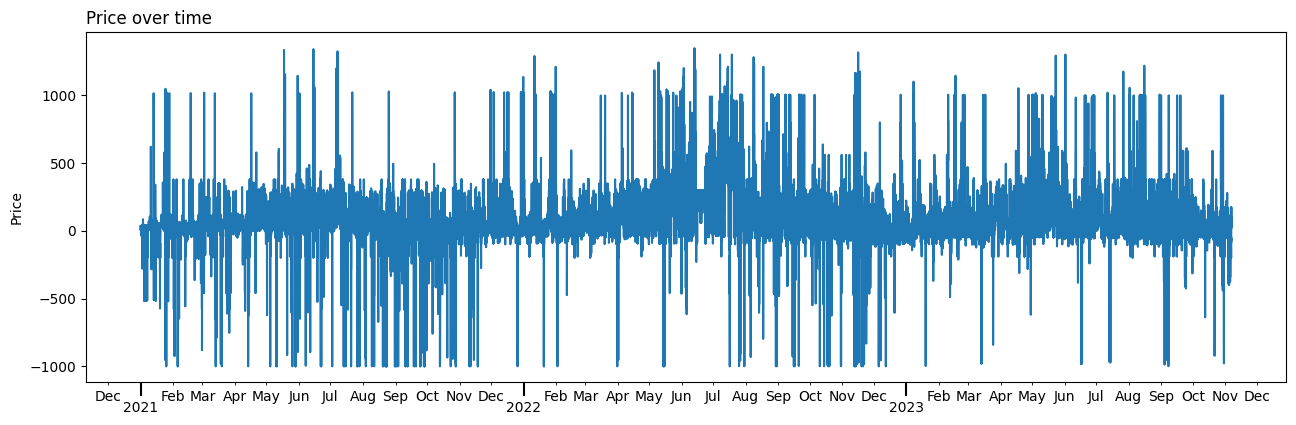

In [6]:
plot_time_series(df_clean['timestamp'], y=df_clean['price'])
plt.show()

In [7]:
df_clean.describe()

,timestamp,price
count,298907,298907.000000
mean,2022-06-04 18:48:13.443780096,83.024152
min,2021-01-01 00:00:00,-1000.000000
25%,2021-09-17 16:47:30,8.675660
50%,2022-06-04 15:45:00,59.971110
75%,2023-02-19 21:12:30,125.653525
max,2023-11-06 20:00:00,1347.922090
std,NaN,132.280888


It can be seen that by keeping only 99.7% of the data, many extreme values were removed, e.g. the maximum price was reduced from 16,600 to 1,347.

## Imputing data
Since we've removed some data by cleaning up the outliers, let's impute by forward filling.

In [8]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
cleaned_data = df_clean.set_index('timestamp')
# Resample to 5-minute intervals and forward-fill missing values
cleaned_data = cleaned_data.resample('5T').ffill()
cleaned_data

,price
timestamp,
2021-01-01 00:00:00,32.30093
2021-01-01 00:05:00,37.23402
2021-01-01 00:10:00,36.67139
2021-01-01 00:15:00,36.03389
2021-01-01 00:20:00,34.92372
...,...
2023-11-06 19:40:00,104.44000
2023-11-06 19:45:00,104.44000
2023-11-06 19:50:00,104.44000


## Create a time series data set
Time series data is characterized by the sequential nature of observations, where each data point is connected to the previous and subsequent points in a chronological order. This temporal dependency is a crucial aspect that needs to be appropriately represented when working with time series data. [1]

To effectively capture the time component, the data points must be arranged in their correct chronological sequence. This sequential ordering ensures that the model can learn and leverage the patterns and relationships that exist between consecutive observations over time.

Failing to maintain the proper temporal order would disrupt the inherent structure of the time series, potentially leading to inaccurate modeling and poor predictive performance. Therefore, preserving the chronological arrangement of the data points is essential for accurately representing and analyzing time series data.

In [9]:
def prepare_dataframe_for_lstm(df, n_steps):
    """prepare DataFrame for timeseries"""
    df = dc(df)
    #df = df.set_index('timestamp')

    for i in range(1, n_steps+1):
        df[f'price (t-{i})'] = df['price'].shift(i)

    df = df.dropna()

    return df

lookback=10  # number of previous time steps to consider as input to predict the next time step
shifted_df = prepare_dataframe_for_lstm(cleaned_data, n_steps=lookback)
shifted_df

,price,price (t-1),price (t-2),price (t-3),price (t-4),price (t-5),price (t-6),price (t-7),price (t-8),price (t-9),price (t-10)
timestamp,,,,,,,,,,,
2021-01-01 00:50:00,34.53839,36.11067,36.51895,36.00552,35.56631,33.91290,34.92372,36.03389,36.67139,37.23402,32.30093
2021-01-01 00:55:00,33.97298,34.53839,36.11067,36.51895,36.00552,35.56631,33.91290,34.92372,36.03389,36.67139,37.23402
2021-01-01 01:00:00,30.21696,33.97298,34.53839,36.11067,36.51895,36.00552,35.56631,33.91290,34.92372,36.03389,36.67139
2021-01-01 01:05:00,28.42243,30.21696,33.97298,34.53839,36.11067,36.51895,36.00552,35.56631,33.91290,34.92372,36.03389
2021-01-01 01:10:00,27.88905,28.42243,30.21696,33.97298,34.53839,36.11067,36.51895,36.00552,35.56631,33.91290,34.92372
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06 19:40:00,104.44000,104.44000,61.22428,75.88231,101.68000,100.85034,113.47940,111.59181,120.28513,121.22936,145.56247
2023-11-06 19:45:00,104.44000,104.44000,104.44000,61.22428,75.88231,101.68000,100.85034,113.47940,111.59181,120.28513,121.22936
2023-11-06 19:50:00,104.44000,104.44000,104.44000,104.44000,61.22428,75.88231,101.68000,100.85034,113.47940,111.59181,120.28513


In this dataframe, the "price" is to be predicted and the remaining columns are considered to be features.

## Create a Numpy array
Since we can't enter a dataframe into our model, we need to convert the data into an array.

In [10]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[ 34.53839,  36.11067,  36.51895, ...,  36.67139,  37.23402,
         32.30093],
       [ 33.97298,  34.53839,  36.11067, ...,  36.03389,  36.67139,
         37.23402],
       [ 30.21696,  33.97298,  34.53839, ...,  34.92372,  36.03389,
         36.67139],
       ...,
       [104.44   , 104.44   , 104.44   , ..., 113.4794 , 111.59181,
        120.28513],
       [104.44   , 104.44   , 104.44   , ..., 100.85034, 113.4794 ,
        111.59181],
       [ 74.41087, 104.44   , 104.44   , ..., 101.68   , 100.85034,
        113.4794 ]])

In [11]:
shifted_df_as_np.shape

(299463, 11)

## Scale the data
The data exhibits a wide range of values, which can negatively impact the model's ability to learn and make accurate predictions. To address this issue, we need to perform scaling or normalization on the data. Scaling involves transforming the data to a common range, typically between 0 and 1 or -1 and 1. This process helps the model converge faster during training and improves its predictive performance.

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.11876259, -0.1174233 , -0.11707552, ..., -0.11694566,
        -0.11646641, -0.1206685 ],
       [-0.11924422, -0.11876259, -0.1174233 , ..., -0.1174887 ,
        -0.11694566, -0.11646641],
       [-0.12244366, -0.11924422, -0.11876259, ..., -0.11843436,
        -0.1174887 , -0.11694566],
       ...,
       [-0.05921921, -0.05921921, -0.05921921, ..., -0.05151929,
        -0.05312718, -0.04572206],
       [-0.05921921, -0.05921921, -0.05921921, ..., -0.06227694,
        -0.05151929, -0.05312718],
       [-0.08479853, -0.05921921, -0.05921921, ..., -0.06157022,
        -0.06227694, -0.05151929]])

In [13]:
# fit scalers for input and output to infer after model training
input_scaler = MinMaxScaler(feature_range=(-1,1))
input_scaler.fit(shifted_df_as_np[:, 1:])

# save input scaler
with open('input_scaler.pkl', 'wb') as f:
    pickle.dump(input_scaler, f)
    
output_scaler = MinMaxScaler(feature_range=(-1,1))
output_scaler.fit(shifted_df_as_np[:, 0].reshape(1,-1))

# save output scaler
with open('output_scaler.pkl', 'wb') as f:
    pickle.dump(output_scaler, f)

## Inspect shapes

In [14]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((299463, 10), (299463,))

## Reverse order of columns
"Reverse the order of columns" means to rearrange the columns of a dataset such that they appear in the opposite sequence compared to their original order.

In the context provided, where columns represent price observations over a time window, "the order will look like price-lookback, price-lookback+1, ... price-1, price" means that the column representing the oldest observation (price-lookback) will be placed first, followed by the next oldest observation (price-lookback+1), and so on, until the most recent observation (price) is placed last.

In simpler terms, it's about flipping the order of columns so that the dataset starts with the oldest price observation and ends with the most recent one.

In [15]:
X = dc(np.flip(X, axis=1))
X

array([[-0.1206685 , -0.11646641, -0.11694566, ..., -0.11751286,
        -0.11707552, -0.1174233 ],
       [-0.11646641, -0.11694566, -0.1174887 , ..., -0.11707552,
        -0.1174233 , -0.11876259],
       [-0.11694566, -0.1174887 , -0.11843436, ..., -0.1174233 ,
        -0.11876259, -0.11924422],
       ...,
       [-0.04572206, -0.05312718, -0.05151929, ..., -0.05921921,
        -0.05921921, -0.05921921],
       [-0.05312718, -0.05151929, -0.06227694, ..., -0.05921921,
        -0.05921921, -0.05921921],
       [-0.05151929, -0.06227694, -0.06157022, ..., -0.05921921,
        -0.05921921, -0.05921921]])

## Perform train-test split

In [16]:
split_index = int(len(X) * 0.8)  # train-test 80:20
split_index

239570

In [17]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((239570, 10), (59893, 10), (239570,), (59893,))

In [18]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((239570, 10, 1), (59893, 10, 1), (239570, 1), (59893, 1))

## Convert arrays to tensors
Since PyTorch needs tensors, we also need to convert the arrays to tensors.

In [19]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([239570, 10, 1]),
 torch.Size([59893, 10, 1]),
 torch.Size([239570, 1]),
 torch.Size([59893, 1]))

## Write dataset class and instantiate
torch.utils.data.Dataset is an abstract class representing a dataset. Our dataset class inherits from "Dataset" and overrides the following methods:
- __len__ so that len(dataset) returns the size of the dataset.
- __getitem__ to support the indexing such that dataset[i] can be used to get i-th sample.


In [20]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

## Create data loaders
torch.utils.data.DataLoader is an iterator which provides features that we would otherwise miss out on:
- Batching the data
- Shuffling the data
- Loading the data in parallel to use multiprocessing workers. 

In [21]:
batch_size = 16 # set batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
# set device to cuda or mps on Mac
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [23]:
# test if the loader works
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


## Write LSTM model
An LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that is particularly well-suited for modelling sequential data, such as time series, text, speech, or any data with temporal dependencies. LSTMs are designed to address the vanishing gradient problem, which is a common issue in traditional RNNs when dealing with long sequences.

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

## Write functions for training and validation

In [25]:
def train_one_epoch(model, loss_function, device, optimizer):
    # set model to training mode
    model.train(True)
    
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.5f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [26]:
def validate_one_epoch(model, loss_function, device):
    # set model to validation mode
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.5f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

## Train and validate the model

In [27]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss() # mean squared error
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam: extension of the stochastic gradient descent (SGD) algorithm

for epoch in range(num_epochs):
    train_one_epoch(model, loss_function, device, optimizer)
    validate_one_epoch(model, loss_function, device)

Epoch: 1
Batch 100, Loss: 0.01539
Batch 200, Loss: 0.01063
Batch 300, Loss: 0.01073
Batch 400, Loss: 0.00968
Batch 500, Loss: 0.00500
Batch 600, Loss: 0.00272
Batch 700, Loss: 0.00313
Batch 800, Loss: 0.00175
Batch 900, Loss: 0.00303
Batch 1000, Loss: 0.00331
Batch 1100, Loss: 0.00208
Batch 1200, Loss: 0.00260
Batch 1300, Loss: 0.00288
Batch 1400, Loss: 0.00218
Batch 1500, Loss: 0.00218
Batch 1600, Loss: 0.00295
Batch 1700, Loss: 0.00188
Batch 1800, Loss: 0.00244
Batch 1900, Loss: 0.00192
Batch 2000, Loss: 0.00229
Batch 2100, Loss: 0.00226
Batch 2200, Loss: 0.00290
Batch 2300, Loss: 0.00336
Batch 2400, Loss: 0.00270
Batch 2500, Loss: 0.00160
Batch 2600, Loss: 0.00183
Batch 2700, Loss: 0.00236
Batch 2800, Loss: 0.00222
Batch 2900, Loss: 0.00153
Batch 3000, Loss: 0.00166
Batch 3100, Loss: 0.00208
Batch 3200, Loss: 0.00173
Batch 3300, Loss: 0.00210
Batch 3400, Loss: 0.00316
Batch 3500, Loss: 0.00342
Batch 3600, Loss: 0.00212
Batch 3700, Loss: 0.00223
Batch 3800, Loss: 0.00230
Batch 3900, 

Batch 900, Loss: 0.00149
Batch 1000, Loss: 0.00255
Batch 1100, Loss: 0.00178
Batch 1200, Loss: 0.00124
Batch 1300, Loss: 0.00250
Batch 1400, Loss: 0.00243
Batch 1500, Loss: 0.00133
Batch 1600, Loss: 0.00280
Batch 1700, Loss: 0.00179
Batch 1800, Loss: 0.00241
Batch 1900, Loss: 0.00240
Batch 2000, Loss: 0.00193
Batch 2100, Loss: 0.00231
Batch 2200, Loss: 0.00243
Batch 2300, Loss: 0.00265
Batch 2400, Loss: 0.00190
Batch 2500, Loss: 0.00149
Batch 2600, Loss: 0.00191
Batch 2700, Loss: 0.00254
Batch 2800, Loss: 0.00123
Batch 2900, Loss: 0.00300
Batch 3000, Loss: 0.00193
Batch 3100, Loss: 0.00273
Batch 3200, Loss: 0.00310
Batch 3300, Loss: 0.00174
Batch 3400, Loss: 0.00255
Batch 3500, Loss: 0.00221
Batch 3600, Loss: 0.00184
Batch 3700, Loss: 0.00174
Batch 3800, Loss: 0.00250
Batch 3900, Loss: 0.00245
Batch 4000, Loss: 0.00283
Batch 4100, Loss: 0.00256
Batch 4200, Loss: 0.00247
Batch 4300, Loss: 0.00206
Batch 4400, Loss: 0.00244
Batch 4500, Loss: 0.00261
Batch 4600, Loss: 0.00132
Batch 4700, L

Batch 1700, Loss: 0.00264
Batch 1800, Loss: 0.00197
Batch 1900, Loss: 0.00254
Batch 2000, Loss: 0.00203
Batch 2100, Loss: 0.00297
Batch 2200, Loss: 0.00315
Batch 2300, Loss: 0.00246
Batch 2400, Loss: 0.00233
Batch 2500, Loss: 0.00191
Batch 2600, Loss: 0.00256
Batch 2700, Loss: 0.00238
Batch 2800, Loss: 0.00161
Batch 2900, Loss: 0.00154
Batch 3000, Loss: 0.00134
Batch 3100, Loss: 0.00162
Batch 3200, Loss: 0.00295
Batch 3300, Loss: 0.00233
Batch 3400, Loss: 0.00228
Batch 3500, Loss: 0.00191
Batch 3600, Loss: 0.00303
Batch 3700, Loss: 0.00211
Batch 3800, Loss: 0.00267
Batch 3900, Loss: 0.00109
Batch 4000, Loss: 0.00287
Batch 4100, Loss: 0.00299
Batch 4200, Loss: 0.00243
Batch 4300, Loss: 0.00204
Batch 4400, Loss: 0.00219
Batch 4500, Loss: 0.00230
Batch 4600, Loss: 0.00218
Batch 4700, Loss: 0.00199
Batch 4800, Loss: 0.00256
Batch 4900, Loss: 0.00133
Batch 5000, Loss: 0.00195
Batch 5100, Loss: 0.00200
Batch 5200, Loss: 0.00300
Batch 5300, Loss: 0.00241
Batch 5400, Loss: 0.00143
Batch 5500, 

Batch 2500, Loss: 0.00352
Batch 2600, Loss: 0.00217
Batch 2700, Loss: 0.00250
Batch 2800, Loss: 0.00211
Batch 2900, Loss: 0.00196
Batch 3000, Loss: 0.00235
Batch 3100, Loss: 0.00175
Batch 3200, Loss: 0.00162
Batch 3300, Loss: 0.00207
Batch 3400, Loss: 0.00336
Batch 3500, Loss: 0.00149
Batch 3600, Loss: 0.00167
Batch 3700, Loss: 0.00113
Batch 3800, Loss: 0.00191
Batch 3900, Loss: 0.00213
Batch 4000, Loss: 0.00176
Batch 4100, Loss: 0.00176
Batch 4200, Loss: 0.00368
Batch 4300, Loss: 0.00207
Batch 4400, Loss: 0.00219
Batch 4500, Loss: 0.00189
Batch 4600, Loss: 0.00154
Batch 4700, Loss: 0.00187
Batch 4800, Loss: 0.00173
Batch 4900, Loss: 0.00156
Batch 5000, Loss: 0.00134
Batch 5100, Loss: 0.00121
Batch 5200, Loss: 0.00138
Batch 5300, Loss: 0.00229
Batch 5400, Loss: 0.00254
Batch 5500, Loss: 0.00151
Batch 5600, Loss: 0.00221
Batch 5700, Loss: 0.00257
Batch 5800, Loss: 0.00309
Batch 5900, Loss: 0.00158
Batch 6000, Loss: 0.00225
Batch 6100, Loss: 0.00178
Batch 6200, Loss: 0.00213
Batch 6300, 

Batch 3300, Loss: 0.00302
Batch 3400, Loss: 0.00315
Batch 3500, Loss: 0.00184
Batch 3600, Loss: 0.00220
Batch 3700, Loss: 0.00252
Batch 3800, Loss: 0.00171
Batch 3900, Loss: 0.00293
Batch 4000, Loss: 0.00194
Batch 4100, Loss: 0.00201
Batch 4200, Loss: 0.00170
Batch 4300, Loss: 0.00231
Batch 4400, Loss: 0.00153
Batch 4500, Loss: 0.00185
Batch 4600, Loss: 0.00170
Batch 4700, Loss: 0.00229
Batch 4800, Loss: 0.00184
Batch 4900, Loss: 0.00328
Batch 5000, Loss: 0.00245
Batch 5100, Loss: 0.00141
Batch 5200, Loss: 0.00190
Batch 5300, Loss: 0.00191
Batch 5400, Loss: 0.00201
Batch 5500, Loss: 0.00235
Batch 5600, Loss: 0.00328
Batch 5700, Loss: 0.00219
Batch 5800, Loss: 0.00217
Batch 5900, Loss: 0.00261
Batch 6000, Loss: 0.00252
Batch 6100, Loss: 0.00187
Batch 6200, Loss: 0.00156
Batch 6300, Loss: 0.00159
Batch 6400, Loss: 0.00142
Batch 6500, Loss: 0.00237
Batch 6600, Loss: 0.00254
Batch 6700, Loss: 0.00109
Batch 6800, Loss: 0.00128
Batch 6900, Loss: 0.00327
Batch 7000, Loss: 0.00148
Batch 7100, 

## First glance at the training results

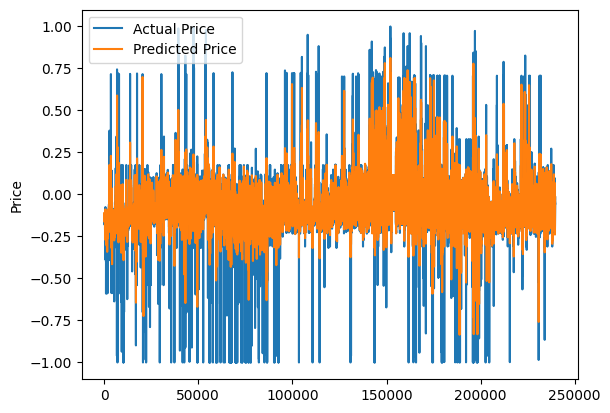

In [28]:
# Disable gradient calculation for inference
with torch.no_grad():
    # Get predictions on training data by passing X_train through the model
    predicted = model(X_train.to(device)).to('cpu').numpy()

# Plot actual and predicted prices for training data
plt.plot(y_train, label='Actual Price')  # Plot actual prices
plt.plot(predicted, label='Predicted Price')  # Plot predicted pricesplt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

The results look promising, but we still need to invert_transfom the data and fix the date axis.

## Reverse Scaling of Data

In [29]:
# Flatten the predicted array
train_predictions = predicted.flatten()

# Create a dummy array with the same shape as X_train
dummies = np.zeros((X_train.shape[0], lookback+1))
# Fill the first column with predicted prices
dummies[:, 0] = train_predictions
# Inverse transform the dummy array using the scaler
dummies = scaler.inverse_transform(dummies)


# Get the first column of the inverse transformed array (predicted prices)
train_predictions = dc(dummies[:, 0])
train_predictions

array([ 41.22215747,  40.4081204 ,  39.79633307, ..., 138.01923698,
       153.70888142, 156.23758489])

In [30]:
# Create a dummy array with the same shape as X_train
dummies = np.zeros((X_train.shape[0], lookback+1))
# Fill the first column with actual prices
dummies[:, 0] = y_train.flatten()
# Inverse transform the dummy array using the scaler
dummies = scaler.inverse_transform(dummies)

# Get the first column of the inverse transformed array (actual prices)
new_y_train = dc(dummies[:, 0])
new_y_train

array([ 34.53839075,  33.97297838,  30.21695667, ..., 160.30745975,
       157.62159027, 137.80173082])

## Plot price forecast

In [31]:
def plot_price_forecast(train_data, pred_data, time_data, train_label, pred_label):
    # Plot time series data
    fig, ax = plt.subplots(figsize=(15, 5))
    
    ax.plot(time_data, train_data, label=train_label)
    ax.plot(time_data, pred_data, label=pred_label)

    # Set major and minor ticks for x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    # adjust length and with of major x-ticks
    ax.tick_params(axis="x", which="major", length=10, width=1.5)

    # Add labels, title and legend
    ax.set_ylabel('Price')
    ax.set_title(f'Price over time', loc='left')
    ax.legend()

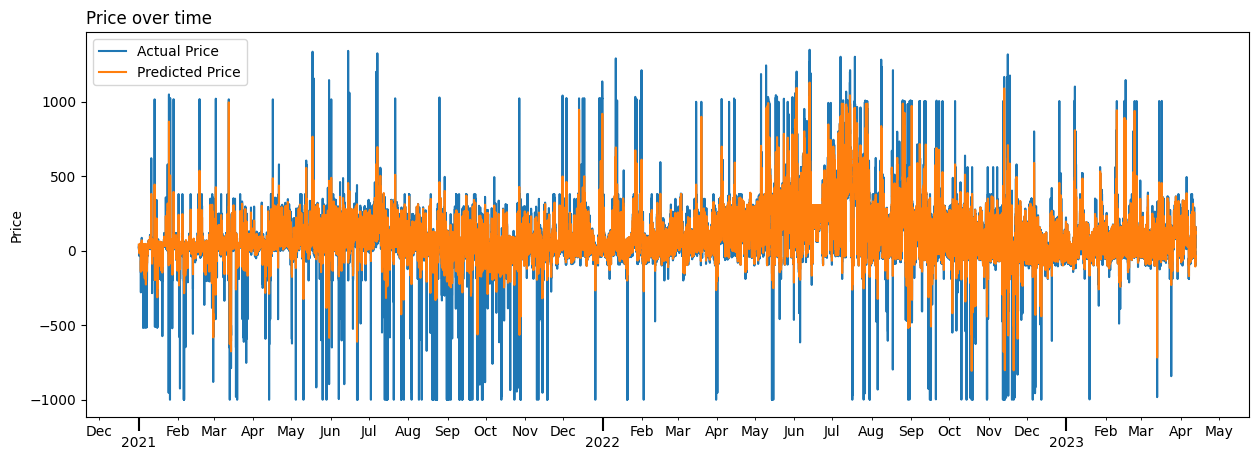

In [32]:
plot_price_forecast(train_data=new_y_train,
                    pred_data=train_predictions,
                    # since the first x=lookback samples can't be used
                    time_data=data['timestamp'][lookback:split_index+lookback],
                    train_label='Actual Price',
                    pred_label='Predicted Price')

plt.show()

The graph visualises the actual prices from the training data alongside the prices predicted by the LSTM model. By comparing the two lines, we can assess how well the model has learned to predict prices based on the training data it has been exposed to.

It is clear that the model struggles to accurately predict the price peaks or extremes in the time series. While the predicted prices generally follow the general trend of the actual prices, there is a noticeable deviation during periods of sharp price increases or decreases.

This observation suggests that the model may have difficulty in capturing and extrapolating the patterns associated with sudden, substantial changes in the time series. The discrepancy between predicted and actual prices is more pronounced during these peak periods, suggesting that the model's predictions tend to underestimate or overestimate the magnitude of such extreme fluctuations.

In [33]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([147.03314853, 147.55618537, 158.34431079, ..., 105.90811243,
       107.24701221, 108.01128936])

In [34]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([141.84132901, 160.90614016, 129.81724143, ..., 104.44000214,
       104.44000214,  74.41086566])

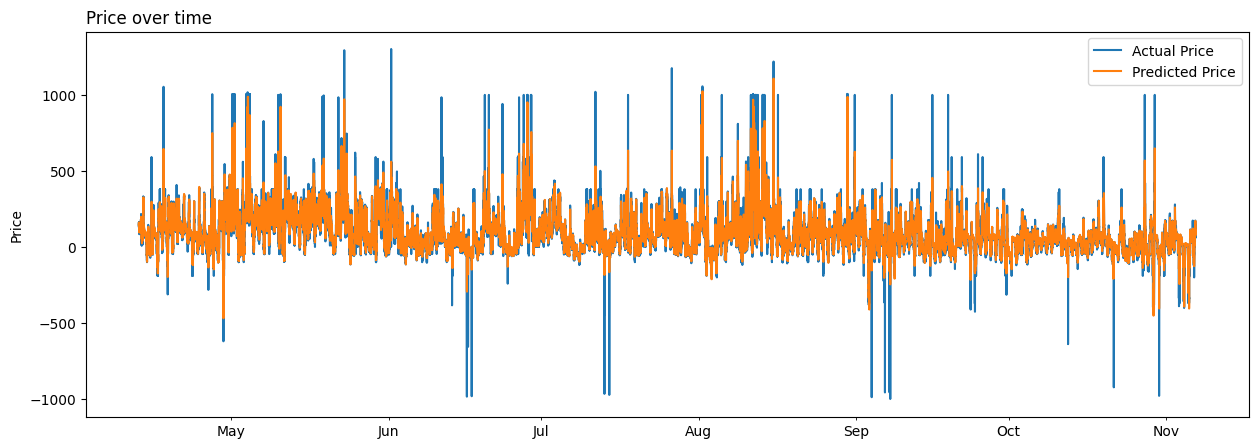

In [35]:
plot_price_forecast(train_data=new_y_test,
                    pred_data=test_predictions,
                    time_data=data['timestamp'][split_index+lookback:],  # considering the lookback
                    train_label='Actual Price',
                    pred_label='Predicted Price')

plt.show()

The graph shows that the model also does a relatively good job of predicting the price on unseen data. As with the training data, the model struggles to accurately capture extreme price movements, but effectively models the overall trend. The trained model serves as a good starting point for further improvement, which could be achieved through the following strategies:

- **Hyperparameter tuning**: Experimenting with different hyperparameters, such as learning rates, number of epochs, or model architecture, can potentially improve the performance of the model and its ability to capture complex patterns.

- **Feature engineering**: Incorporating additional relevant features that influence energy prices, such as temperature, weather conditions or economic indicators, can provide the model with more contextual information and potentially improve its predictive capabilities.

- **Ensemble Methods**: Combining multiple models, each with their own strengths and weaknesses, through ensemble techniques such as bagging or boosting can often lead to more robust and accurate predictions.

- **Advanced Model Architectures**: Exploring more sophisticated neural network architectures, such as attention mechanisms or hybrid models that combine LSTM with other techniques such as convolutional neural networks (CNNs) or transformers, can potentially capture more complex patterns in time series data.

By implementing these strategies and continuously iterating the model, it is possible to improve its ability to capture extreme price movements while maintaining its ability to model the overall trend, ultimately leading to more accurate and reliable energy price forecasts.

## Save model

In [36]:
filename_model = f'{model.__class__.__name__}_{num_epochs}epochs.pt'
torch.save(model.state_dict(), filename_model)

## Load model

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1)
filename_state_dict = 'LSTM_10epochs.pt'
model.load_state_dict(torch.load(filename_state_dict))
model.eval()

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)